<a href="https://colab.research.google.com/github/Kimxbzheng/notebooks/blob/master/convolution_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 6: Convolutions by examples

We'll build our first Convolutional Neural Network (CNN) from scratch.

## 1. Preparations

In [3]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

In [4]:
import torch
import torchvision
from torchvision import models,transforms,datasets

Download MNIST data on disk and convert it to pytorch compatible formating.

```torchvision.datasets``` features support (download, formatting) for a collection of popular datasets. The list of available datasets in ```torchvision``` can be found [here](http://pytorch.org/docs/master/torchvision/datasets.html).

Note that the download is performed only once. The function will always check first if the data is already on disk.


In [5]:
root_dir = './data/MNIST/'
torchvision.datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train

MNIST datasets consists of small images of hand-written digits. The images are grayscale and have size 28 x 28. There are 60,000 training images and 10,000 testing images.

In [6]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True)

Define and initialize a data loader for the MNIST data already downloaded on disk.

In [7]:
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)

For the current notebook, we can format data as _numpy ndarrays_ which are easier to plot in matplotlib. The same operations can be easily performed on _pytorch Tensors_.

In [8]:
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()

In [9]:
print(images.shape,labels.shape)

(60000, 28, 28) (60000,)


## 2. Data visualization

For convenience we define a few functions for formatting and plotting our image data

In [10]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

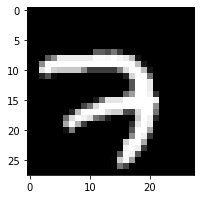

In [11]:
plot(images[5000])

In [12]:
labels[5000]

7

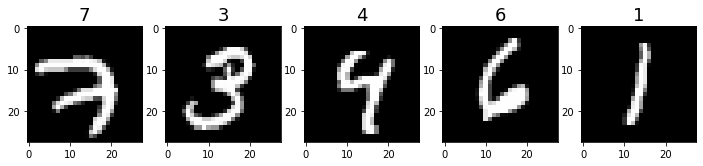

In [13]:
plots(images[5000:5005], titles=labels[5000:5005])

## 3. Extract Number 8 and 1


In [14]:
n=len(images)

In [15]:
eights=[images[i] for i in range(n) if labels[i]==8]
ones=[images[i] for i in range(n) if labels[i]==1]

## 5. Practicals: improving classification with Convolutional Neural Net

You will now build a neural net that will learn the weights of the filters.

The first layer of your network will be a convolutional layer with $8$ filters of size $3\times 3$. Then you will apply a Max Pooling layer to reduce the size of the image to $4\times 4$ as we did above. This will produce a (once flatten) a vector of size $128 = 4\times 4\times 8$. From this vector, you need to predict if the corresponding input is a $1$ or a $8$. So you are back to a classification problem as seen in previous lesson.

You need to fill the code written below to construct your CNN. You will need to look for documentation about [torch.nn](https://pytorch.org/docs/stable/nn.html) in the Pytorch doc.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()
        # fill the missing entries below
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=128, out_features=2)
        
    def forward(self,x):
        # implement your network here, use F.max_pool2d, F.log_softmax and do not forget to flatten your vector
        x = self.conv1(x)
        x = F.max_pool2d(x, 7, stride=7)
        x = torch.flatten(x,start_dim=1)
        # print(x.size())
        x = self.fc(x)
        # print(x.size())
        x = F.log_softmax(x,dim=1)
        return x

In [17]:
conv_class = classifier()

Your code should work fine on a batch of 3 images.

In [18]:
batch_3images = train_set.data[0:2].type(torch.FloatTensor).resize_(3, 1, 28, 28)
#conv_class(batch_3images)

The following lines of code implement a data loader for the train set and the test set. No modification is needed.

In [19]:
bs = 64

l8 = np.array(0)
eights_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l8.astype(np.int64))] for e in eights]
l1 = np.array(1)
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l1.astype(np.int64))] for e in ones]
train_dataset = eights_dataset[1000:] + ones_dataset[1000:]
test_dataset = eights_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=bs, shuffle=True)

You need now to code the training loop. Store the loss and accuracy for each epoch.

In [20]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1):
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
            #
            # Your code here
            outputs = model(inputs)
            loss = loss_fn(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == labels.data)
            #
            size += bs
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

In [21]:
conv_class = classifier()
# choose the appropriate loss
loss_fn = nn.NLLLoss()
# your SGD optimizer
learning_rate = 1e-3
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr=learning_rate)
# and train for 10 epochs
l_t, a_t = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0053 Acc: 0.9341
Train - Loss: 0.0014 Acc: 0.9807
Train - Loss: 0.0008 Acc: 0.9870
Train - Loss: 0.0006 Acc: 0.9905
Train - Loss: 0.0005 Acc: 0.9914
Train - Loss: 0.0004 Acc: 0.9929
Train - Loss: 0.0004 Acc: 0.9927
Train - Loss: 0.0003 Acc: 0.9935
Train - Loss: 0.0003 Acc: 0.9940
Train - Loss: 0.0003 Acc: 0.9946


Let's learn for 10 more epochs

In [22]:
l_t1, a_t1 = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0003 Acc: 0.9945
Train - Loss: 0.0003 Acc: 0.9951
Train - Loss: 0.0002 Acc: 0.9953
Train - Loss: 0.0002 Acc: 0.9955
Train - Loss: 0.0002 Acc: 0.9954
Train - Loss: 0.0002 Acc: 0.9957
Train - Loss: 0.0002 Acc: 0.9956
Train - Loss: 0.0002 Acc: 0.9957
Train - Loss: 0.0002 Acc: 0.9958
Train - Loss: 0.0002 Acc: 0.9962


Our network seems to learn but we now need to check its accuracy on the test set.

In [23]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
            
        bs = labels.size(0)
        #
        # Your code here
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        _,preds = torch.max(outputs.data,1)
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == labels.data)
        #
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [24]:
test(conv_class,test_loader)

Test - Loss: 0.0003 Acc: 0.9920


How many parameters did your network learn?

In [30]:
total = sum([param.nelement() for param in conv_class.parameters()])
print("Number of parameter: %d" % (total))

Number of parameter: 338


You can see them as follows:

In [26]:
for m in conv_class.children():
    print('weights :', m.weight.data)
    print('bias :', m.bias.data)

weights : tensor([[[[ 0.7134,  0.1111,  0.0812],
          [ 0.5917, -0.0801, -0.5183],
          [ 0.5428,  0.4368, -0.6772]]],


        [[[ 0.0493, -0.6220, -0.4873],
          [ 0.4858,  0.1119,  0.2369],
          [ 0.2469,  0.2249,  0.4706]]],


        [[[-0.1370, -0.0583,  0.2649],
          [ 0.3813, -0.0073,  0.3167],
          [ 0.1070,  0.2996,  0.3644]]],


        [[[ 0.0134,  0.5788,  0.6775],
          [ 0.2746, -0.1420,  0.0448],
          [-0.2684, -0.8237, -0.3475]]],


        [[[ 0.5076,  0.2029,  0.2213],
          [ 0.0939,  0.2734,  0.4915],
          [-0.5535, -0.5878,  0.1393]]],


        [[[ 0.4664, -0.2027, -0.5069],
          [ 0.2982,  0.1038, -0.4230],
          [ 0.1539,  0.5426,  0.1072]]],


        [[[ 0.6871,  0.2553, -0.6347],
          [ 0.2207, -0.1331, -0.0372],
          [ 0.3129,  0.3671,  0.3068]]],


        [[[-0.3790,  0.2524,  0.3151],
          [ 0.2874,  0.1463,  0.3094],
          [ 0.6129,  0.5549,  0.5595]]]])
bias : tensor([-0.3554,

In [27]:
for m in conv_class.children():
    T_w = m.weight.data.numpy()
    T_b = m.bias.data.numpy()
    break

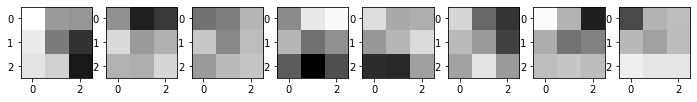

In [28]:
plots([T_w[i][0] for i in range(8)])

In [29]:
T_b

array([-0.35537785, -0.37237677, -0.5471257 , -0.22622085, -0.57380384,
       -0.49607772, -0.29775128,  0.34214112], dtype=float32)